In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
plt.style.use("ggplot")

precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

ratings = pd.read_excel('data/ratings.xlsx')
#ratings = ratings[ratings['Category']=='Premier cru 1855']

#selected_vineyards = list(ratings['Chateau'].unique())
selected_vineyards = ['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Château Pavie', 'Petrus Pomerol', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac']
print(selected_vineyards)

ratings['Rating - Avg'] = (ratings['Rating - LB'] + ratings['Rating - HB'])/2
ratings = ratings.groupby('Vintage')['Rating - Avg'].mean().to_frame()


prices = pd.read_excel('data/prices.xlsx', index_col=0)
df = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df = df.replace(-100, np.NaN)
selected_prices = df[(df['Chateau'].isin(selected_vineyards))].fillna(method='ffill')
display(selected_prices['Chateau'].unique())
prices = selected_prices.groupby('Vintage')['Price'].mean().to_frame()

y = prices
y['Log Price'] = np.log(y['Price'])

['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Château Pavie', 'Petrus Pomerol', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac']


array(['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac',
       'Château Mouton Rothschild Pauillac', 'Château Margaux',
       'Château Haut-Brion Pessac-léognan',
       'Château Pichon-Longueville Baron Pauillac',
       'Château Pichon-Longueville Comtesse de Lalande Pauillac',
       'Château Montrose Saint-Estèphe',
       'Château Ducru-Beaucaillou Saint-Julien',
       'Château Léoville Las Cases Saint-Julien', 'Château Ausone',
       'Château Cheval Blanc', 'Château Pavie', 'Château Figeac',
       'Château Trotte Vieille', 'Château Angélus', 'Château Palmer',
       'Petrus Pomerol'], dtype=object)

In [3]:
X = pd.DataFrame(index = precipitations.index).loc[1950:]

X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important


X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2


X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])

X['Square Winter Temperature'] = X['Winter Temperature']**2

X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Square Summer Temperature'] = X['Summer Temperature']**2


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2

X['Square Harvest Temperature'] = X['Harvest Temperature']**2

#X['Past Year Quality'] = y['Log Price'].shift(1).fillna(0) - y['Log Price'].rolling(10).mean().shift(1).fillna(0)
X['Frost Days'] = frost_days['Mar']+ 3*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

#X['Severe Frost Days'] = (severe_frost_days['Sep'].shift(1).fillna(0) + severe_frost_days['Oct'].shift(1).fillna(0) + severe_frost_days['Nov'].shift(1).fillna(0))*3 + severe_frost_days['Dec'].shift(1).fillna(0)*2 + severe_frost_days['Jan'] + severe_frost_days['Fev'] + severe_frost_days['Mar']*2 + severe_frost_days['Mar']*3

X['Frost Days Prev Fall'] = 2*frost_days['Oct'].shift(1).fillna(0)+ frost_days['Nov'].shift(1).fillna(0) + frost_days['Dec'].shift(1).fillna(0)
display(X.tail())

from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1950:,:]

COLUMN_NAMES = X.columns.to_list()
print(COLUMN_NAMES)

,Winter Rain,Harvest Rain,Winter Temperature,Square Winter Temperature,Summer Temperature,Square Summer Temperature,Harvest Temperature,Square Harvest Temperature,Frost Days,Frost Days Prev Fall
Year,,,,,,,,,,
2015,54.3,273.1,40.3,1624.09,163.0,26569.00,204.5,41820.25,0,6.0
2016,12.5,321.3,57.1,3260.41,151.1,22831.21,225.8,50985.64,2,2.0
2017,13.2,402.7,45.1,2034.01,166.7,27788.89,213.6,45624.96,0,4.0
2018,162.7,180.9,42.9,1840.41,164.6,27093.16,230.7,53222.49,1,11.0
2019,93.2,348.4,52.2,2724.84,157.9,24932.41,230.3,53038.09,0,4.0


['Winter Rain', 'Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature', 'Frost Days', 'Frost Days Prev Fall']


In [4]:
import torch

class Regressive_Model(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length):
        super().__init__()
        
        self.weights = {}
        self.init_dict = init_dict
        self.length = length
        self.type = {}
        
        self.weights_intercept = torch.nn.Parameter(torch.from_numpy(init_dict['intercept']['weight']))
        self.weights_winter_rain = torch.nn.Parameter(torch.from_numpy(init_dict['Winter Rain']['weight']))
        self.weights_harvest_rain = torch.nn.Parameter(torch.tensor(init_dict['Harvest Rain']['weight']))
        self.weights_frost_days = torch.nn.Parameter(torch.from_numpy(init_dict['Frost Days']['weight']))
        self.weights_frost_days_prev_fall = torch.nn.Parameter(torch.from_numpy(init_dict['Frost Days Prev Fall']['weight']))

        self.weights_winter_temperature = torch.nn.Parameter(torch.tensor(init_dict['Winter Temperature']['weight']))
        self.weights_square_winter_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Winter Temperature']['weight']))
        self.weights_summer_temperature = torch.nn.Parameter(torch.tensor(init_dict['Summer Temperature']['weight']))
        self.weights_square_summer_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Summer Temperature']['weight']))
        self.weights_harvest_temperature = torch.nn.Parameter(torch.tensor(init_dict['Harvest Temperature']['weight']))
        self.weights_square_harvest_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Harvest Temperature']['weight']))

        self.register_parameter('intercept', self.weights_intercept)
        
        self.register_parameter('Winter Rain', self.weights_winter_rain)
        self.register_parameter('Frost Days', self.weights_frost_days)
        self.register_parameter('Frost Days Prev Fall', self.weights_frost_days_prev_fall)
        self.walk_params = torch.nn.ParameterList([self.weights_winter_rain, self.weights_frost_days, self.weights_frost_days_prev_fall])
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Winter Rain', 'Frost Days', 'Frost Days Prev Fall']]
        
        self.register_parameter('Harvest Rain', self.weights_harvest_rain)
        self.register_parameter('Winter Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Winter Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Summer Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Summer Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Harvest Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Harvest Temperature', self.weights_square_winter_temperature)
        self.scalar_params = torch.nn.ParameterList(
            [
                self.weights_harvest_rain,
                self.weights_winter_temperature,
                self.weights_square_winter_temperature,
                self.weights_summer_temperature,
                self.weights_square_summer_temperature,
                self.weights_harvest_temperature,
                self.weights_square_harvest_temperature
            ])
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature']]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def loss_regularize_intercept(self):
        return torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1]))
        return loss
            
    #def loss_keep_close_to_prior(self):
    #    loss = 0
    #    for coeff in self.weights.keys():
    #        loss += torch.mean((self.weights[coeff] - self.init_dict[coeff])*(self.weights[coeff] - self.init_dict[coeff]))
    #    
    #    loss += self.weights_intercept
    #    
    #    for i in range(len(walk_params)):
    #        loss += torch.mean((self.weights[coeff] - self.init_dict[coeff])*(self.weights[coeff] - self.init_dict[coeff]))
    #        
    #    for i in range(len(scalar_params)):
    #        loss += self.scalar_params[i] * X[self.scalar_coeff_names[i],:]
    #    return loss
    
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 1000*self.loss_regularize_walk_coeffs()\
                + 100*self.loss_regularize_intercept()
                #+ self.loss_keep_close_to_prior()

X_tensor = torch.FloatTensor(X.values)
y_tensor = torch.from_numpy(y['Log Price'].values)
def training_loop(model, optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = model.combined_loss(X_tensor, y_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)  
    return losses

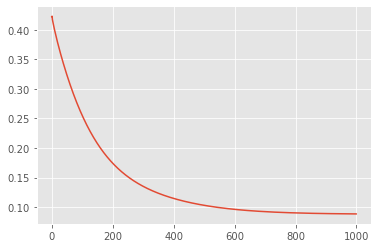

In [5]:
init_dict = {}
init_dict['intercept'] = {
    'type':'walk',
    'weight': np.ones(len(y))*(-0.25)
}
init_dict['Winter Rain'] = {
    'type':'walk',
    'weight': np.ones(len(y))*0.05
}
init_dict['Harvest Rain'] = {
    'type':'scalar',
    'weight': -0.1
}
init_dict['Winter Temperature'] = {
    'type':'scalar',
    'weight': -0.35
}
init_dict['Square Winter Temperature'] = {
    'type':'scalar',
    'weight': -0.35
}
init_dict['Summer Temperature'] = {
    'type':'scalar',
    'weight': 0.5
}
init_dict['Square Summer Temperature'] = {
    'type':'scalar',
    'weight': -0.4
}
init_dict['Harvest Temperature'] = {
    'type':'scalar',
    'weight': 1.6
}
init_dict['Square Harvest Temperature'] = {
    'type':'scalar',
    'weight': -1.6
}
init_dict['Frost Days'] = {
    'type':'walk',
    'weight': np.ones(len(y))*(-0.25)
}
init_dict['Frost Days Prev Fall'] = {
    'type':'walk',
    'weight': np.ones(len(y))*(-0.25)
}

model = Regressive_Model(init_dict, len(y))
optimizer = torch.optim.Adam(model.parameters())

losses = training_loop(model, optimizer)
plt.plot(losses)

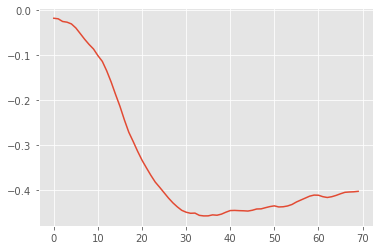

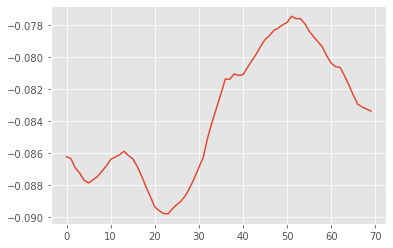

In [6]:
plt.plot(model.intercept.detach().numpy())
plt.show()
plt.plot(model.weights_frost_days_prev_fall.detach().numpy())

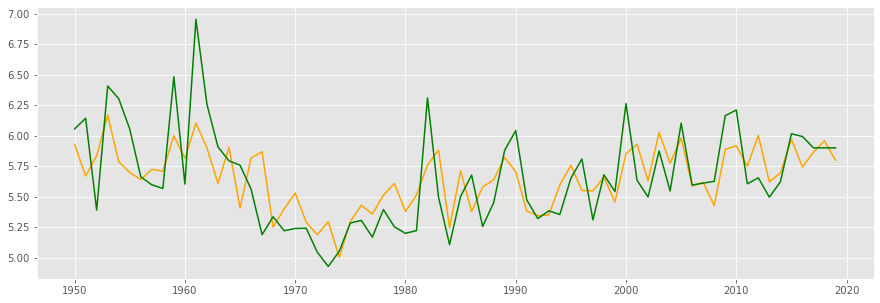

In [7]:
plt.figure(figsize=(15,5))
full_predictions  = model(X_tensor).detach().numpy()
predictions = full_predictions[44:-4]
plt.plot(range(1950, 2020), full_predictions, color='orange')
plt.plot(y['Log Price'], color='g')


# With positive winter temperature

Spearman correlation between results and real log prices: 
 0.6600790513833994
Spearman correlation between results and real log prices / full: 
 0.7332073561432942

R2 between results and real log prices: 
 -0.8644427092256128
R2 between results and real log prices / full: 
 -0.3401487103827696

MAE between results and real log prices: 
 0.175365613101509
MAE between results and real log prices / full: 
 0.21831199332429826


Spearman correlation between results and real log prices: 
 0.6442687747035574
Spearman correlation between results and real log prices / full: 
 0.723094151230973

R2 between results and real log prices: 
 -0.31226360022086075
R2 between results and real log prices / full: 
 -0.2645779879430865

MAE between results and real log prices: 
 0.1731616250109538
MAE between results and real log prices / full: 
 0.2195074312288997


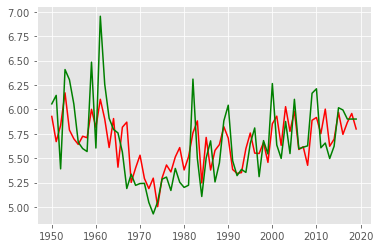

In [8]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

plt.plot(range(1950, 2020), full_predictions, color='r')
plt.plot(y['Log Price'], color='g')
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2015, 'Log Price']).correlation)
print('Spearman correlation between results and real log prices / full: \n', spearmanr(full_predictions, y.loc[1950:2019, 'Log Price']).correlation)

print('\nR2 between results and real log prices: \n', r2_score(predictions, y.loc[1994:2015, 'Log Price']))
print('R2 between results and real log prices / full: \n', r2_score(full_predictions, y['Log Price']))

print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions - y.loc[1994:2015, 'Log Price'])))
print('MAE between results and real log prices / full: \n', np.mean(np.abs(full_predictions - y['Log Price'])))

# Ante 1994 model

In [191]:
import torch

class Initial_Model(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length):
        super().__init__()
        
        self.weights = {}
        self.init_dict = init_dict
        self.length = length
        self.type = {}
        
        self.weights_intercept = torch.nn.Parameter(torch.from_numpy(init_dict['intercept']['weight']))
        self.weights_winter_rain = torch.nn.Parameter(torch.from_numpy(init_dict['Winter Rain']['weight']))
        self.weights_harvest_rain = torch.nn.Parameter(torch.tensor(init_dict['Harvest Rain']['weight']))
        self.weights_frost_days = torch.nn.Parameter(torch.from_numpy(init_dict['Frost Days']['weight']))
        self.weights_frost_days_prev_fall = torch.nn.Parameter(torch.from_numpy(init_dict['Frost Days Prev Fall']['weight']))

        self.weights_winter_temperature = torch.nn.Parameter(torch.tensor(init_dict['Winter Temperature']['weight']))
        self.weights_square_winter_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Winter Temperature']['weight']))
        self.weights_summer_temperature = torch.nn.Parameter(torch.tensor(init_dict['Summer Temperature']['weight']))
        self.weights_square_summer_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Summer Temperature']['weight']))
        self.weights_harvest_temperature = torch.nn.Parameter(torch.tensor(init_dict['Harvest Temperature']['weight']))
        self.weights_square_harvest_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Harvest Temperature']['weight']))

        self.register_parameter('intercept', self.weights_intercept)
        
        self.register_parameter('Winter Rain', self.weights_winter_rain)
        self.register_parameter('Frost Days', self.weights_frost_days)
        self.register_parameter('Frost Days Prev Fall', self.weights_frost_days_prev_fall)
        self.walk_params = torch.nn.ParameterList([self.weights_winter_rain,self.weights_frost_days, self.weights_frost_days_prev_fall])
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Winter Rain','Frost Days', 'Frost Days Prev Fall']]
        
        self.register_parameter('Harvest Rain', self.weights_harvest_rain)
        self.register_parameter('Winter Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Winter Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Summer Temperature', self.weights_summer_temperature)
        self.register_parameter('Square Summer Temperature', self.weights_square_summer_temperature)
        self.register_parameter('Harvest Temperature', self.weights_harvest_temperature)
        self.register_parameter('Square Harvest Temperature', self.weights_square_harvest_temperature)
        self.scalar_params = torch.nn.ParameterList(
            [
                self.weights_harvest_rain,
                self.weights_winter_temperature,
                self.weights_square_winter_temperature,
                self.weights_summer_temperature,
                self.weights_square_summer_temperature,
                self.weights_harvest_temperature,
                self.weights_square_harvest_temperature
            ])
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in [
            'Harvest Rain',
            'Winter Temperature',
            'Square Winter Temperature',
            'Summer Temperature',
            'Square Summer Temperature',
            'Harvest Temperature',
            'Square Harvest Temperature']]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def predict_extra_vintage(self, X):
        """ 
        Predicts the vintage just after the trained range, based on data in X
        """
        result = torch.ones(1)*6
        coefficients = {}
        coefficients['intercept'] = self.weights_intercept[-1]
        result += coefficients['intercept']
        
        for i in range(len(self.walk_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_walks[i]]
            coefficients[coeff_name] = self.walk_params[i][-1]
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
            
        for i in range(len(self.scalar_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_scalars[i]]
            coefficients[coeff_name] = self.scalar_params[i]
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
        return result, coefficients
    
    def loss_regularize_walk(self):
        loss = 0
        for t in self.walk_params:
            loss += 20000*torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1]))
            
        loss += 30* torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))
        return loss
            
    #def loss_keep_close_to_prior(self):
    #    loss = 0
    #    for coeff in self.weights.keys():
    #        loss += torch.mean((self.weights[coeff] - self.init_dict[coeff])*(self.weights[coeff] - self.init_dict[coeff]))
    #    
    #    loss += self.weights_intercept
    #    
    #    for i in range(len(walk_params)):
    #        loss += torch.mean((self.weights[coeff] - self.init_dict[coeff])*(self.weights[coeff] - self.init_dict[coeff]))
    #        
    #    for i in range(len(scalar_params)):
    #        loss += self.scalar_params[i] * X[self.scalar_coeff_names[i],:]
    #    return loss
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + self.loss_regularize_walk() #+ self.loss_keep_close_to_prior()

def training_loop(model, optimizer, n=10000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n)):
        loss = model.combined_loss(X_tensor, y_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.detach().numpy().item())
    return losses

In [192]:
def define_init_dict(len):
    init_dict = {}
    init_dict['intercept'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }
    init_dict['Winter Rain'] = {
        'type':'walk',
        'weight': np.ones(len)*0.05
    }
    init_dict['Harvest Rain'] = {
        'type':'scalar',
        'weight': -0.1
    }
    init_dict['Winter Temperature'] = {
        'type':'scalar',
        'weight': -0.35
    }
    init_dict['Square Winter Temperature'] = {
        'type':'scalar',
        'weight': 0.35
    }
    init_dict['Summer Temperature'] = {
        'type':'scalar',
        'weight': 0.5
    }
    init_dict['Square Summer Temperature'] = {
        'type':'scalar',
        'weight': -0.4
    }
    init_dict['Harvest Temperature'] = {
        'type':'scalar',
        'weight': 1.6
    }
    init_dict['Square Harvest Temperature'] = {
        'type':'scalar',
        'weight': -1.6
    }
    init_dict['Frost Days'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }
    init_dict['Frost Days Prev Fall'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }
    
    
    return init_dict

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 785.48it/s]


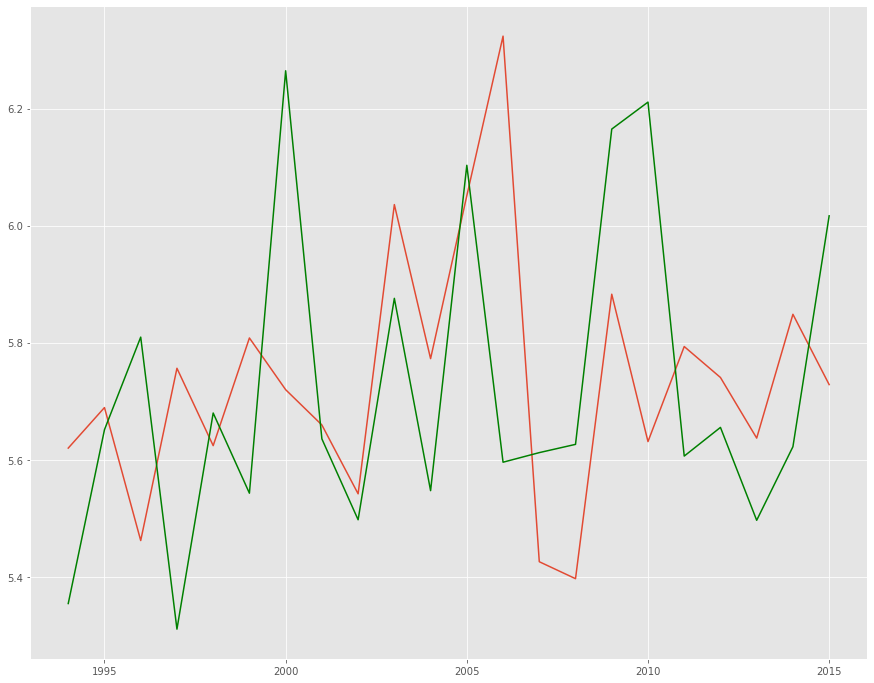

Spearman correlation between results and real log prices: 
 0.11575381140598533
dict_keys(['intercept', 'Winter Rain', 'Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature', 'Frost Days', 'Frost Days Prev Fall'])


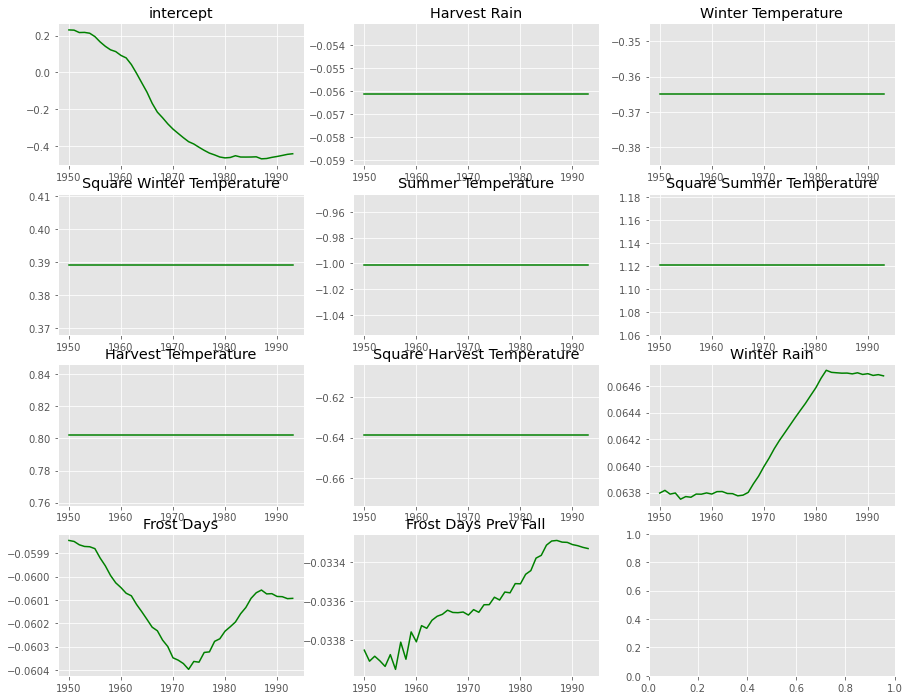

In [193]:

X_tensor = torch.FloatTensor(X.loc[1950 : 1993, :].values)
y_tensor = torch.from_numpy(y.loc[1950 : 1993, 'Log Price'].values)
    
training_length = 1994-1950
vintage_model_1994 = Initial_Model(define_init_dict(training_length), training_length)
optimizer = torch.optim.Adam(vintage_model_1994.parameters())
losses = training_loop(vintage_model_1994, optimizer)

predictions=[]
for vintage in tqdm(range(1994, 2016)):
    predictions.append(vintage_model_1994.predict_extra_vintage(X.loc[vintage, :])[0].detach().numpy()[0])
          
plt.plot(range(1994, 2016), predictions)
plt.plot(y.loc[1994:2015, 'Log Price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2015, 'Log Price'].values).correlation)


plt.rcParams['figure.figsize']= [15, 12]

fig, axs = plt.subplots(4,3)
print(coefficients_record.keys())
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(1950, 1994), vintage_model_1994.weights_intercept.detach().numpy(), color='green')

subplot.set_title('intercept')

    
for i in range(len(vintage_model_1994.scalar_params)):
    n = i+1
    subplot = axs[n//3, n%3]
    subplot.plot(range(1950, 1994), [vintage_model_1994.scalar_params[i]]*44, color='green')

    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_scalars[i]])


for i in range(len(vintage_model_1994.walk_params)):
    n = len(vintage_model_1994.scalar_params) + i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(1950, 1994), vintage_model_1994.walk_params[i].detach().numpy(), color='green')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])



0.15 avec l'init suivante:

init_dict['intercept'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }
    init_dict['Winter Rain'] = {
        'type':'walk',
        'weight': np.ones(len)*0.05
    }
    init_dict['Harvest Rain'] = {
        'type':'scalar',
        'weight': -0.1
    }
    init_dict['Winter Temperature'] = {
        'type':'scalar',
        'weight': -0.35
    }
    init_dict['Summer Temperature'] = {
        'type':'scalar',
        'weight': 0.5
    }
    init_dict['Harvest Temperature'] = {
        'type':'scalar',
        'weight': 1.6
    }
    init_dict['Square Harvest Temperature'] = {
        'type':'scalar',
        'weight': -1.6
    }
    init_dict['Frost Days'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }
    init_dict['Frost Days Prev Fall'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }

0.11 avec par défaut

# Varying coeffs

In [194]:
import copy

def extend_tensor(tensor, extension):
    value = tensor.detach().data.clone().numpy()
    new_value = np.ones(np.size(value)+extension)*copy.deepcopy(value[-1])
    new_value[:-extension] = copy.deepcopy(value)
    return torch.nn.Parameter(torch.from_numpy(new_value))
    
def copy_tensor(tensor):
    return torch.nn.Parameter(copy.deepcopy(tensor.detach().data.clone()), requires_grad=False)
    
class Additional_Model(torch.nn.Module):
    """Optimizes over the previous model's dataframe + one year"""
    def __init__(self, prev_model, length, print_all = False):
        super().__init__()
        
        self.weights = {}
        self.init_dict = init_dict
        self.length = length
        self.extension = self.length - prev_model.length
        self.type = {}
        self.print_all = print_all
        
        # Save init value
        self.register_buffer('init_intercept', prev_model.weights_intercept)
        self.register_buffer('init_winter_rain', prev_model.weights_winter_rain)
        self.register_buffer('init_frost_days', prev_model.weights_frost_days)
        self.register_buffer('init_frost_days_prev_fall', prev_model.weights_frost_days_prev_fall)
        self.init_walk_params = torch.nn.ParameterList([self.init_winter_rain, self.init_frost_days, self.init_frost_days_prev_fall])

        self.register_buffer('init_harvest_rain', prev_model.weights_harvest_rain)
        self.register_buffer('init_winter_temperature', prev_model.weights_winter_temperature)
        self.register_buffer('init_square_winter_temperature', prev_model.weights_square_winter_temperature)
        self.register_buffer('init_summer_temperature', prev_model.weights_summer_temperature)
        self.register_buffer('init_square_summer_temperature', prev_model.weights_square_summer_temperature)
        self.register_buffer('init_harvest_temperature', prev_model.weights_harvest_temperature)
        self.register_buffer('init_square_harvest_temperature', prev_model.weights_square_harvest_temperature)
        self.init_scalar_params = torch.nn.ParameterList(
            [
                self.init_harvest_rain,
                self.init_winter_temperature,
                self.init_square_winter_temperature,
                self.init_summer_temperature,
                self.init_square_summer_temperature,
                self.init_harvest_temperature,
                self.init_square_harvest_temperature
            ])
        
        
        self.weights_intercept = extend_tensor(prev_model.weights_intercept, self.extension)
        self.weights_winter_rain = extend_tensor(prev_model.weights_winter_rain, self.extension)
        self.weights_frost_days = extend_tensor(prev_model.weights_frost_days, self.extension)
        self.weights_frost_days_prev_fall = extend_tensor(prev_model.weights_frost_days_prev_fall, self.extension)

        self.weights_harvest_rain = copy_tensor(prev_model.weights_harvest_rain)
        self.weights_winter_temperature = copy_tensor(prev_model.weights_winter_temperature)
        self.weights_square_winter_temperature = copy_tensor(prev_model.weights_square_winter_temperature)
        self.weights_summer_temperature = copy_tensor(prev_model.weights_summer_temperature)
        self.weights_square_summer_temperature = copy_tensor(prev_model.weights_square_summer_temperature)
        self.weights_harvest_temperature = copy_tensor(prev_model.weights_harvest_temperature)
        self.weights_square_harvest_temperature = copy_tensor(prev_model.weights_square_harvest_temperature)
        
        self.register_parameter('intercept', self.weights_intercept)
        self.register_parameter('Winter Rain', self.weights_winter_rain)
        self.register_parameter('Frost Days', self.weights_frost_days)
        self.register_parameter('Frost Days Prev Fall', self.weights_frost_days_prev_fall)
        self.walk_params = torch.nn.ParameterList([self.weights_winter_rain, self.weights_frost_days, self.weights_frost_days_prev_fall])
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Winter Rain', 'Frost Days', 'Frost Days Prev Fall']]
        
        self.register_parameter('Harvest Rain', self.weights_harvest_rain)
        self.register_parameter('Winter Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Winter Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Summer Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Summer Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Harvest Temperature', self.weights_harvest_temperature)
        self.register_parameter('Square Harvest Temperature', self.weights_square_harvest_temperature)
        self.scalar_params = torch.nn.ParameterList(
            [
                self.weights_harvest_rain,
                self.weights_winter_temperature,
                self.weights_square_winter_temperature,
                self.weights_summer_temperature,
                self.weights_square_summer_temperature,
                self.weights_harvest_temperature,
                self.weights_square_harvest_temperature
            ])
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature']]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def predict_extra_vintage(self, X):
        """ 
        Predicts the vintage just after the trained range, based on data in X
        """
        result = torch.ones(1)*6
        coefficients = {}
        coefficients['intercept'] = self.weights_intercept[-1]
        result += coefficients['intercept']
            
        for i in range(len(self.walk_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_walks[i]]
            coefficients[coeff_name] = self.walk_params[i][-1]
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
            
        for i in range(len(self.scalar_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_scalars[i]]
            coefficients[coeff_name] = self.scalar_params[i]
            
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
        return result, coefficients
    
    def loss_regularize_walk(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1]))
            loss += torch.mean((t[2:] - t[:-2])*(t[2:] - t[:-2]))
            
        #print(torch.mean(torch.abs(self.weights_intercept[1:] - self.weights_intercept[:-1])))
        loss += torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))

        #loss += torch.mean((self.weights_intercept[2:] - self.weights_intercept[:-2])*(self.weights_intercept[2:] - self.weights_intercept[:-2]))

        return loss
            
    def loss_keep_close_to_prior(self):
        loss = 0
        loss += 100*torch.mean((self.weights_intercept[:-self.extension] - self.init_intercept)*(self.weights_intercept[:-self.extension] - self.init_intercept))
        
        for i in range(len(self.walk_params)):
            # Keep common part close
            loss += torch.mean((self.walk_params[i][:-self.extension] - self.init_walk_params[i])*(self.walk_params[i][:-self.extension] - self.init_walk_params[i]))
            
            # Keep the end part close - activate or not
            #loss += (self.walk_params[i][-1] - self.init_walk_params[i][-1])*(self.walk_params[i][-1] - self.init_walk_params[i][-1])
        
        for i in range(len(self.scalar_params)):
            #if self.print_all:
                #print('\n',COLUMN_NAMES[self.where_to_find_scalars[i]])
                #print(self.scalar_params[i])
                #print(self.init_scalar_params[i])
            loss += 2*torch.mean((self.scalar_params[i] -self.init_scalar_params[i])*(self.scalar_params[i] -self.init_scalar_params[i]))
            
        return loss
    
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        #print('LOSS TARGET', 0*self.loss_target(X, y))
        #print('LOSS regwalk', self.loss_regularize_walk())
        #print('LOSS KEEP CLOSE', self.loss_keep_close_to_prior())

        return 1*self.loss_target(X, y) + 100*self.loss_regularize_walk() + 10*self.loss_keep_close_to_prior()

    

In [195]:
from tqdm import tqdm
predictions = []
coefficients_record = {}
plot=True

X_tensor = torch.FloatTensor(X.loc[1950 : 1993, :].values)
y_tensor = torch.from_numpy(y.loc[1950 : 1993, 'Log Price'].values)
    
training_length = 1994-1950
vintage_model_1994 = Initial_Model(define_init_dict(training_length), training_length)
optimizer = torch.optim.Adam(vintage_model_1994.parameters())
losses = training_loop(vintage_model_1994, optimizer)

result_tuple = vintage_model_1994.predict_extra_vintage(torch.FloatTensor(X.loc[1994, :].values))
prediction, coefficients  = result_tuple[0].detach().numpy()[0], result_tuple[1]
print(prediction)
predictions.append(prediction)
    
for coeff in list(define_init_dict(0).keys()):
    coefficients_record[coeff] = [coefficients[coeff].detach().numpy()]
        
vintage_models = [vintage_model_1994]
for param in vintage_model_1994.parameters():
    param.requires_grad = False
    
    
intercepts= []
init_intercepts = []
for vintage in tqdm(range(1995, 2016)):
    print(vintage)
    X_tensor = torch.FloatTensor(X.loc[1950 : vintage-1, :].values)
    y_tensor = torch.from_numpy(y.loc[1950 : vintage-1, 'Log Price'].values)
    training_length = vintage-1950
    
    if vintage==1995:
        last_model = Additional_Model(vintage_model_1994, training_length)

    else:
        last_model = Additional_Model(vintage_model_1994, training_length)
        
        
    optimizer2 = torch.optim.Adam(last_model.parameters(), lr=0.6)
    training_loop(last_model, optimizer2)
    #print(last_model.loss_keep_close_to_prior())
    #print('Init:\n',last_model.init_intercept)
    #print('Actual:\n',last_model.intercept)
    init_intercepts.append(last_model.init_intercept.detach().numpy())

    intercepts.append(last_model.weights_intercept.detach().numpy())

    last_model.zero_grad()
    
    result_tuple = last_model.predict_extra_vintage(torch.FloatTensor(X.loc[vintage, :].values))
    prediction, coefficients  = result_tuple[0].detach().numpy()[0], result_tuple[1]
    predictions.append(prediction)
    vintage_models.append(last_model)
    
    for coeff in list(define_init_dict(0).keys()):
        coefficients_record[coeff].append(coefficients[coeff].detach().numpy())
        

  0%|▏                                                                             | 19/10000 [00:00<00:54, 182.68it/s]

5.6200533
1995



 10%|███████▊                                                                    | 1032/10000 [00:07<01:02, 142.63it/s]


 20%|███████████████▏                                                            | 2003/10000 [00:14<01:03, 126.33it/s]


 30%|██████████████████████▍                                                     | 2954/10000 [00:22<00:58, 121.38it/s]


 40%|██████████████████████████████▏                                             | 3972/10000 [00:29<00:40, 150.65it/s]


 51%|██████████████████████████████████████▍                                     | 5057/10000 [00:36<00:32, 152.77it/s]


 62%|██████████████████████████████████████████████▊                             | 6157/10000 [00:43<00:24, 154.98it/s]


 72%|██████████████████████████████████████████████████████▉                     | 7235/10000 [00:50<00:18, 149.74it/s]


 83%|███████████████████████████████████████████████████████████████             | 8301/10000 [00:57<00:11, 143.89it/s]


 93%|██████████████████████████████████████████████████████████████████████▌     | 9279/10000 [01:04<00:04, 147.22it/s]


  0%|                                                                              | 14/10000 [00:00<01:14, 133.29it/s]

1996



  9%|███████▎                                                                     | 943/10000 [00:07<01:07, 133.89it/s]


 19%|██████████████▌                                                             | 1923/10000 [00:14<00:55, 144.87it/s]


 29%|██████████████████████                                                      | 2899/10000 [00:21<00:56, 125.99it/s]


 39%|█████████████████████████████▍                                              | 3869/10000 [00:28<00:45, 136.00it/s]


 49%|█████████████████████████████████████▏                                      | 4890/10000 [00:35<00:31, 163.37it/s]


 59%|████████████████████████████████████████████▊                               | 5902/10000 [00:43<00:30, 133.12it/s]


 69%|████████████████████████████████████████████████████▎                       | 6883/10000 [00:50<00:21, 142.13it/s]


 78%|███████████████████████████████████████████████████████████▍                | 7824/10000 [00:57<00:16, 130.16it/s]


 88%|██████████████████████████████████████████████████████████████████▌         | 8759/10000 [01:04<00:09, 127.04it/s]


 97%|█████████████████████████████████████████████████████████████████████████▉  | 9722/10000 [01:12<00:01, 139.57it/s]


  0%|                                                                              | 15/10000 [00:00<01:08, 145.74it/s]


1997


 10%|███████▊                                                                    | 1024/10000 [00:07<01:04, 139.96it/s]


 20%|███████████████▎                                                            | 2007/10000 [00:14<00:58, 136.09it/s]


 30%|██████████████████████▌                                                     | 2971/10000 [00:21<00:45, 155.92it/s]


 40%|██████████████████████████████▏                                             | 3964/10000 [00:28<00:50, 119.78it/s]


 49%|█████████████████████████████████████▌                                      | 4945/10000 [00:35<00:41, 121.67it/s]


 59%|█████████████████████████████████████████████                               | 5936/10000 [00:43<00:31, 129.62it/s]


 69%|████████████████████████████████████████████████████▌                       | 6913/10000 [00:50<00:21, 146.04it/s]


 79%|███████████████████████████████████████████████████████████▋                | 7856/10000 [00:57<00:16, 127.39it/s]


 88%|███████████████████████████████████████████████████████████████████         | 8816/10000 [01:04<00:09, 131.25it/s]


 97%|██████████████████████████████████████████████████████████████████████████  | 9738/10000 [01:12<00:02, 121.46it/s]


  0%|                                                                              | 12/10000 [00:00<01:23, 119.62it/s]

1998



  9%|██████▋                                                                      | 872/10000 [00:07<01:13, 123.89it/s]


 18%|█████████████▉                                                              | 1827/10000 [00:14<00:58, 139.59it/s]


 28%|█████████████████████                                                       | 2775/10000 [00:21<00:47, 150.79it/s]


 37%|████████████████████████████▍                                               | 3747/10000 [00:28<00:49, 125.66it/s]


 47%|███████████████████████████████████▊                                        | 4713/10000 [00:35<00:38, 136.51it/s]


 57%|███████████████████████████████████████████▏                                | 5677/10000 [00:43<00:28, 149.31it/s]


 66%|██████████████████████████████████████████████████▍                         | 6636/10000 [00:50<00:26, 128.28it/s]


 76%|██████████████████████████████████████████████████████████                  | 7638/10000 [00:57<00:16, 145.69it/s]


 87%|██████████████████████████████████████████████████████████████████          | 8685/10000 [01:04<00:09, 140.63it/s]


 97%|█████████████████████████████████████████████████████████████████████████▊  | 9705/10000 [01:11<00:02, 123.31it/s]


  0%|                                                                              | 14/10000 [00:00<01:12, 137.62it/s]

1999



 10%|███████▌                                                                     | 990/10000 [00:07<01:05, 136.64it/s]


 21%|███████████████▊                                                            | 2075/10000 [00:14<00:50, 156.74it/s]


 31%|███████████████████████▌                                                    | 3102/10000 [00:21<00:50, 136.07it/s]


 41%|███████████████████████████████▍                                            | 4136/10000 [00:28<00:38, 151.25it/s]


 52%|███████████████████████████████████████▎                                    | 5178/10000 [00:36<00:34, 138.65it/s]


 62%|██████████████████████████████████████████████▉                             | 6183/10000 [00:43<00:30, 125.64it/s]


 71%|██████████████████████████████████████████████████████▏                     | 7124/10000 [00:50<00:22, 125.39it/s]


 81%|█████████████████████████████████████████████████████████████▌              | 8104/10000 [00:57<00:13, 142.72it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 9101/10000 [01:05<00:05, 149.87it/s]


  0%|                                                                              | 13/10000 [00:00<01:17, 128.28it/s]

2000



 10%|███████▋                                                                    | 1004/10000 [00:07<01:07, 132.96it/s]


 20%|███████████████▌                                                            | 2040/10000 [00:14<00:54, 147.07it/s]


 30%|██████████████████████▉                                                     | 3018/10000 [00:21<00:47, 145.54it/s]


 41%|██████████████████████████████▊                                             | 4060/10000 [00:29<00:37, 156.33it/s]


 51%|██████████████████████████████████████▉                                     | 5118/10000 [00:36<00:33, 147.16it/s]


 62%|███████████████████████████████████████████████                             | 6188/10000 [00:43<00:27, 137.06it/s]


 73%|███████████████████████████████████████████████████████▍                    | 7297/10000 [00:50<00:17, 158.29it/s]


 84%|███████████████████████████████████████████████████████████████▉            | 8409/10000 [00:57<00:09, 164.74it/s]


 95%|████████████████████████████████████████████████████████████████████████▎   | 9516/10000 [01:04<00:03, 146.65it/s]


  0%|▏                                                                             | 17/10000 [00:00<00:58, 169.82it/s]


2001


 11%|████████▌                                                                   | 1126/10000 [00:07<00:56, 156.53it/s]


 22%|████████████████▉                                                           | 2222/10000 [00:14<00:49, 156.53it/s]


 33%|█████████████████████████▎                                                  | 3327/10000 [00:21<00:40, 166.28it/s]


 44%|█████████████████████████████████▎                                          | 4375/10000 [00:28<00:39, 140.94it/s]


 54%|█████████████████████████████████████████                                   | 5396/10000 [00:36<00:36, 127.79it/s]


 65%|█████████████████████████████████████████████████▎                          | 6492/10000 [00:43<00:22, 156.53it/s]


 75%|█████████████████████████████████████████████████████████▏                  | 7528/10000 [00:50<00:18, 137.21it/s]


 86%|█████████████████████████████████████████████████████████████████           | 8567/10000 [00:58<00:09, 156.31it/s]


 96%|█████████████████████████████████████████████████████████████████████████▏  | 9631/10000 [01:05<00:02, 129.76it/s]


  0%|                                                                              | 13/10000 [00:00<01:17, 128.36it/s]

2002



 10%|███████▉                                                                    | 1042/10000 [00:07<00:57, 156.73it/s]


 22%|████████████████▍                                                           | 2170/10000 [00:14<00:45, 173.07it/s]


 33%|█████████████████████████▏                                                  | 3321/10000 [00:21<00:44, 149.39it/s]


 43%|████████████████████████████████▉                                           | 4328/10000 [00:29<00:37, 150.39it/s]


 54%|█████████████████████████████████████████▍                                  | 5446/10000 [00:36<00:32, 140.74it/s]


 65%|█████████████████████████████████████████████████▏                          | 6470/10000 [00:43<00:25, 138.58it/s]


 75%|█████████████████████████████████████████████████████████▎                  | 7533/10000 [00:50<00:16, 151.15it/s]


 86%|█████████████████████████████████████████████████████████████████▌          | 8630/10000 [00:57<00:09, 149.38it/s]


 97%|█████████████████████████████████████████████████████████████████████████▍  | 9657/10000 [01:05<00:02, 128.79it/s]


  0%|                                                                              | 12/10000 [00:00<01:23, 119.23it/s]

2003



 10%|███████▉                                                                    | 1049/10000 [00:07<01:03, 140.84it/s]


 22%|████████████████▌                                                           | 2183/10000 [00:14<00:48, 159.87it/s]


 33%|████████████████████████▊                                                   | 3259/10000 [00:21<00:51, 130.95it/s]


 43%|████████████████████████████████▉                                           | 4333/10000 [00:28<00:34, 165.00it/s]


 54%|█████████████████████████████████████████▎                                  | 5439/10000 [00:36<00:27, 167.45it/s]


 65%|█████████████████████████████████████████████████▏                          | 6477/10000 [00:43<00:26, 132.48it/s]


 74%|████████████████████████████████████████████████████████▌                   | 7439/10000 [00:50<00:17, 145.94it/s]


 84%|███████████████████████████████████████████████████████████████▊            | 8402/10000 [00:57<00:12, 128.97it/s]


 95%|████████████████████████████████████████████████████████████████████████▏   | 9498/10000 [01:04<00:03, 163.93it/s]


  0%|▏                                                                             | 17/10000 [00:00<00:59, 169.01it/s]

2004



 11%|████████▍                                                                   | 1102/10000 [00:07<01:00, 147.25it/s]


 21%|███████████████▉                                                            | 2102/10000 [00:14<01:17, 101.50it/s]


 32%|████████████████████████▏                                                   | 3178/10000 [00:21<00:44, 152.36it/s]


 42%|███████████████████████████████▉                                            | 4204/10000 [00:29<00:47, 122.59it/s]


 52%|███████████████████████████████████████▊                                    | 5244/10000 [00:36<00:37, 125.69it/s]


 63%|████████████████████████████████████████████████▏                           | 6345/10000 [00:43<00:21, 167.55it/s]


 74%|████████████████████████████████████████████████████████▌                   | 7444/10000 [00:50<00:16, 153.97it/s]


 85%|████████████████████████████████████████████████████████████████▊           | 8522/10000 [00:57<00:09, 150.91it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 9578/10000 [01:04<00:03, 139.61it/s]


  0%|                                                                               | 10/10000 [00:00<01:40, 99.65it/s]

2005



 10%|███████▌                                                                     | 985/10000 [00:07<01:04, 140.57it/s]


 21%|███████████████▊                                                            | 2082/10000 [00:14<00:48, 161.67it/s]


 32%|████████████████████████                                                    | 3170/10000 [00:21<00:49, 137.96it/s]


 42%|███████████████████████████████▋                                            | 4166/10000 [00:28<00:39, 149.09it/s]


 53%|███████████████████████████████████████▉                                    | 5254/10000 [00:35<00:29, 162.21it/s]


 63%|████████████████████████████████████████████████▏                           | 6347/10000 [00:42<00:25, 143.72it/s]


 74%|████████████████████████████████████████████████████████                    | 7383/10000 [00:49<00:16, 160.99it/s]


 84%|████████████████████████████████████████████████████████████████▏           | 8448/10000 [00:56<00:10, 154.37it/s]


 94%|███████████████████████████████████████████████████████████████████████▊    | 9449/10000 [01:04<00:03, 153.36it/s]


  0%|                                                                              | 14/10000 [00:00<01:11, 139.50it/s]

2006



 10%|███████▋                                                                    | 1010/10000 [00:07<01:01, 145.24it/s]


 20%|███████████████▌                                                            | 2045/10000 [00:14<00:58, 137.11it/s]


 31%|███████████████████████▎                                                    | 3062/10000 [00:21<00:53, 130.09it/s]


 41%|███████████████████████████████                                             | 4084/10000 [00:28<00:38, 152.85it/s]


 51%|██████████████████████████████████████▌                                     | 5076/10000 [00:35<00:34, 144.63it/s]


 61%|██████████████████████████████████████████████▎                             | 6099/10000 [00:42<00:32, 120.67it/s]


 71%|██████████████████████████████████████████████████████▏                     | 7135/10000 [00:50<00:22, 125.82it/s]


 82%|██████████████████████████████████████████████████████████████              | 8163/10000 [00:57<00:12, 144.17it/s]


 92%|█████████████████████████████████████████████████████████████████████▋      | 9175/10000 [01:04<00:06, 137.32it/s]


  0%|                                                                              | 13/10000 [00:00<01:19, 125.75it/s]

2007



 10%|███████▋                                                                     | 999/10000 [00:07<01:03, 140.97it/s]


 20%|██████████████▉                                                             | 1970/10000 [00:14<00:53, 150.41it/s]


 30%|██████████████████████▌                                                     | 2963/10000 [00:21<00:44, 158.34it/s]


 40%|██████████████████████████████▏                                             | 3966/10000 [00:28<00:42, 140.36it/s]


 50%|██████████████████████████████████████                                      | 5003/10000 [00:36<00:37, 133.72it/s]


 60%|█████████████████████████████████████████████▌                              | 5992/10000 [00:43<00:31, 127.74it/s]


 70%|█████████████████████████████████████████████████████▍                      | 7029/10000 [00:50<00:23, 127.51it/s]


 80%|████████████████████████████████████████████████████████████▉               | 8011/10000 [00:57<00:13, 144.54it/s]


 90%|████████████████████████████████████████████████████████████████████▌       | 9027/10000 [01:04<00:06, 154.65it/s]


  0%|                                                                              | 13/10000 [00:00<01:17, 128.36it/s]

2008



 10%|███████▉                                                                    | 1047/10000 [00:07<01:00, 147.10it/s]


 21%|████████████████                                                            | 2111/10000 [00:14<00:54, 145.50it/s]


 31%|███████████████████████▉                                                    | 3142/10000 [00:21<00:48, 142.24it/s]


 41%|███████████████████████████████▍                                            | 4138/10000 [00:28<00:46, 126.35it/s]


 52%|███████████████████████████████████████▎                                    | 5170/10000 [00:36<00:30, 158.10it/s]


 62%|██████████████████████████████████████████████▉                             | 6179/10000 [00:43<00:24, 154.75it/s]


 71%|██████████████████████████████████████████████████████▎                     | 7143/10000 [00:50<00:21, 132.46it/s]


 81%|█████████████████████████████████████████████████████████████▍              | 8092/10000 [00:57<00:16, 118.63it/s]


 91%|████████████████████████████████████████████████████████████████████▉       | 9070/10000 [01:04<00:06, 146.08it/s]


  0%|                                                                              | 15/10000 [00:00<01:08, 145.22it/s]


2009


 10%|███████▎                                                                     | 957/10000 [00:07<01:10, 128.80it/s]


 20%|██████████████▊                                                             | 1954/10000 [00:14<00:57, 140.07it/s]


 30%|██████████████████████▍                                                     | 2958/10000 [00:21<00:50, 140.30it/s]


 40%|██████████████████████████████▏                                             | 3973/10000 [00:28<00:40, 148.53it/s]


 50%|█████████████████████████████████████▋                                      | 4955/10000 [00:35<00:38, 130.70it/s]


 59%|█████████████████████████████████████████████                               | 5925/10000 [00:43<00:29, 136.11it/s]


 69%|████████████████████████████████████████████████████▋                       | 6932/10000 [00:50<00:20, 151.99it/s]


 80%|████████████████████████████████████████████████████████████▊               | 8007/10000 [00:57<00:14, 140.40it/s]


 90%|████████████████████████████████████████████████████████████████████▋       | 9039/10000 [01:04<00:07, 136.91it/s]


  0%|                                                                              | 13/10000 [00:00<01:19, 125.07it/s]

2010



 10%|███████▉                                                                    | 1045/10000 [00:07<01:02, 143.06it/s]


 21%|███████████████▉                                                            | 2096/10000 [00:14<00:53, 149.02it/s]


 31%|███████████████████████▊                                                    | 3126/10000 [00:21<00:48, 142.28it/s]


 42%|███████████████████████████████▌                                            | 4150/10000 [00:28<00:40, 146.18it/s]


 51%|███████████████████████████████████████                                     | 5146/10000 [00:35<00:32, 151.48it/s]


 62%|███████████████████████████████████████████████▍                            | 6247/10000 [00:43<00:22, 164.57it/s]


 74%|███████████████████████████████████████████████████████▉                    | 7362/10000 [00:50<00:16, 157.59it/s]


 85%|████████████████████████████████████████████████████████████████▏           | 8451/10000 [00:57<00:10, 149.08it/s]


 96%|████████████████████████████████████████████████████████████████████████▋   | 9561/10000 [01:04<00:02, 148.89it/s]


  0%|                                                                              | 14/10000 [00:00<01:11, 139.51it/s]

2011



 11%|████████▋                                                                   | 1141/10000 [00:07<00:51, 172.57it/s]


 23%|█████████████████▎                                                          | 2274/10000 [00:14<00:46, 166.76it/s]


 34%|█████████████████████████▊                                                  | 3395/10000 [00:21<00:43, 150.25it/s]


 45%|██████████████████████████████████                                          | 4487/10000 [00:28<00:31, 172.67it/s]


 55%|██████████████████████████████████████████▏                                 | 5543/10000 [00:36<00:36, 121.23it/s]


 65%|█████████████████████████████████████████████████▌                          | 6526/10000 [00:43<00:25, 135.31it/s]


 76%|█████████████████████████████████████████████████████████▊                  | 7602/10000 [00:50<00:14, 165.03it/s]


 87%|██████████████████████████████████████████████████████████████████▍         | 8736/10000 [00:57<00:08, 154.67it/s]


 98%|██████████████████████████████████████████████████████████████████████████▋ | 9826/10000 [01:05<00:01, 158.10it/s]


  0%|▏                                                                             | 19/10000 [00:00<00:53, 185.14it/s]

2012



 11%|████████▌                                                                   | 1124/10000 [00:07<00:59, 149.08it/s]


 22%|████████████████▋                                                           | 2192/10000 [00:14<00:59, 131.23it/s]


 33%|█████████████████████████▏                                                  | 3306/10000 [00:21<00:44, 149.72it/s]


 44%|█████████████████████████████████▍                                          | 4395/10000 [00:28<00:36, 153.46it/s]


 54%|████████████████████████████████████████▉                                   | 5380/10000 [00:36<00:32, 143.66it/s]


 64%|████████████████████████████████████████████████▉                           | 6435/10000 [00:43<00:25, 141.06it/s]


 75%|████████████████████████████████████████████████████████▊                   | 7469/10000 [00:50<00:16, 155.06it/s]


 84%|███████████████████████████████████████████████████████████████▊            | 8389/10000 [00:58<00:11, 139.30it/s]


 95%|████████████████████████████████████████████████████████████████████████    | 9485/10000 [01:05<00:03, 153.91it/s]


  0%|                                                                              | 13/10000 [00:00<01:16, 129.97it/s]

2013



 11%|████████▌                                                                   | 1129/10000 [00:07<01:10, 125.20it/s]


 22%|█████████████████                                                           | 2243/10000 [00:14<00:47, 164.96it/s]


 34%|█████████████████████████▊                                                  | 3397/10000 [00:21<00:42, 154.87it/s]


 44%|█████████████████████████████████▊                                          | 4449/10000 [00:28<00:42, 130.51it/s]


 55%|██████████████████████████████████████████                                  | 5540/10000 [00:36<00:26, 168.01it/s]


 66%|██████████████████████████████████████████████████▎                         | 6620/10000 [00:43<00:26, 125.74it/s]


 77%|██████████████████████████████████████████████████████████▊                 | 7743/10000 [00:50<00:15, 145.68it/s]


 89%|███████████████████████████████████████████████████████████████████▍        | 8875/10000 [00:57<00:07, 160.48it/s]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:04<00:00, 154.33it/s]


  0%|                                                                              | 16/10000 [00:00<01:02, 159.53it/s]

2014



 11%|████████▌                                                                   | 1127/10000 [00:07<00:54, 162.12it/s]


 22%|████████████████▌                                                           | 2182/10000 [00:14<00:50, 154.77it/s]


 33%|████████████████████████▋                                                   | 3252/10000 [00:21<00:46, 144.78it/s]


 43%|████████████████████████████████▉                                           | 4327/10000 [00:28<00:36, 155.85it/s]


 54%|█████████████████████████████████████████▍                                  | 5448/10000 [00:35<00:34, 132.91it/s]


 66%|█████████████████████████████████████████████████▊                          | 6555/10000 [00:42<00:24, 139.63it/s]


 76%|█████████████████████████████████████████████████████████▉                  | 7619/10000 [00:50<00:16, 144.83it/s]


 87%|██████████████████████████████████████████████████████████████████▍         | 8749/10000 [00:57<00:07, 157.99it/s]


 99%|██████████████████████████████████████████████████████████████████████████▉ | 9858/10000 [01:04<00:01, 135.32it/s]


  0%|                                                                              | 16/10000 [00:00<01:02, 159.45it/s]

2015



 11%|████████▌                                                                   | 1128/10000 [00:07<01:04, 137.19it/s]


 22%|████████████████▌                                                           | 2172/10000 [00:14<00:51, 152.95it/s]


 33%|█████████████████████████▏                                                  | 3308/10000 [00:21<00:41, 159.98it/s]


 44%|█████████████████████████████████▎                                          | 4390/10000 [00:28<00:40, 138.99it/s]


 54%|█████████████████████████████████████████                                   | 5396/10000 [00:35<00:34, 133.27it/s]


 64%|████████████████████████████████████████████████▉                           | 6441/10000 [00:43<00:24, 144.14it/s]


 75%|████████████████████████████████████████████████████████▉                   | 7494/10000 [00:50<00:15, 160.14it/s]


 86%|█████████████████████████████████████████████████████████████████▍          | 8604/10000 [00:57<00:09, 143.96it/s]


 97%|█████████████████████████████████████████████████████████████████████████▍  | 9664/10000 [01:04<00:02, 128.01it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [24:16<00:00, 69.37s/it]


[4.8528776, 4.944598, 5.087451, 5.119754, 5.0193114, 5.275343, 5.3610806, 5.0440936, 5.4136415, 5.563469, 5.342409, 5.9420724, 5.980395, 5.211611, 5.0999393, 5.8852506, 6.050541, 5.8018103, 5.7850204, 5.321948, 5.02889, 5.7760167]
Spearman correlation between results and real log prices: 
 0.3574251835121401

R2 between results and real log prices: 
 -0.4420300800509147

MAE between results and real log prices: 
 0.38154149370783297


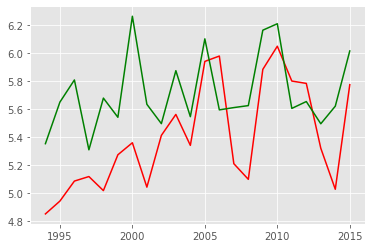

In [70]:
plt.plot(range(1994, 2016), predictions, color='r')
plt.plot(y.loc[1994:2015, 'Log Price'], color='g')
print(predictions)
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2015, 'Log Price']).correlation)
print('\nR2 between results and real log prices: \n', r2_score(predictions, y.loc[1994:2015, 'Log Price']))
print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions - y.loc[1994:2015, 'Log Price'])))

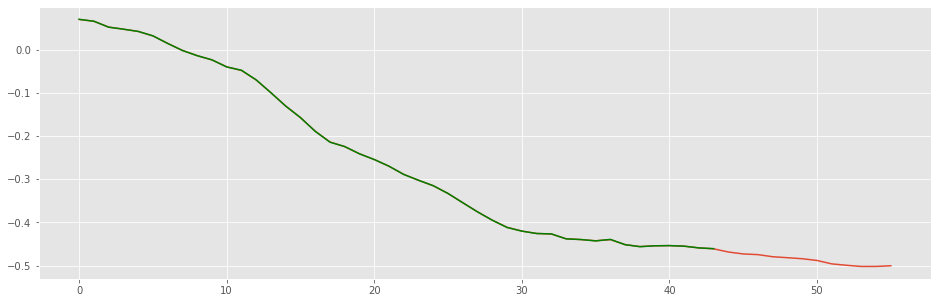

In [82]:
plt.figure(figsize=(16,5))
plt.plot(intercepts[11])

plt.plot(last_model.init_intercept, color='green')
plt.show()

dict_keys(['intercept', 'Winter Rain', 'Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature', 'Frost Days', 'Frost Days Prev Fall'])


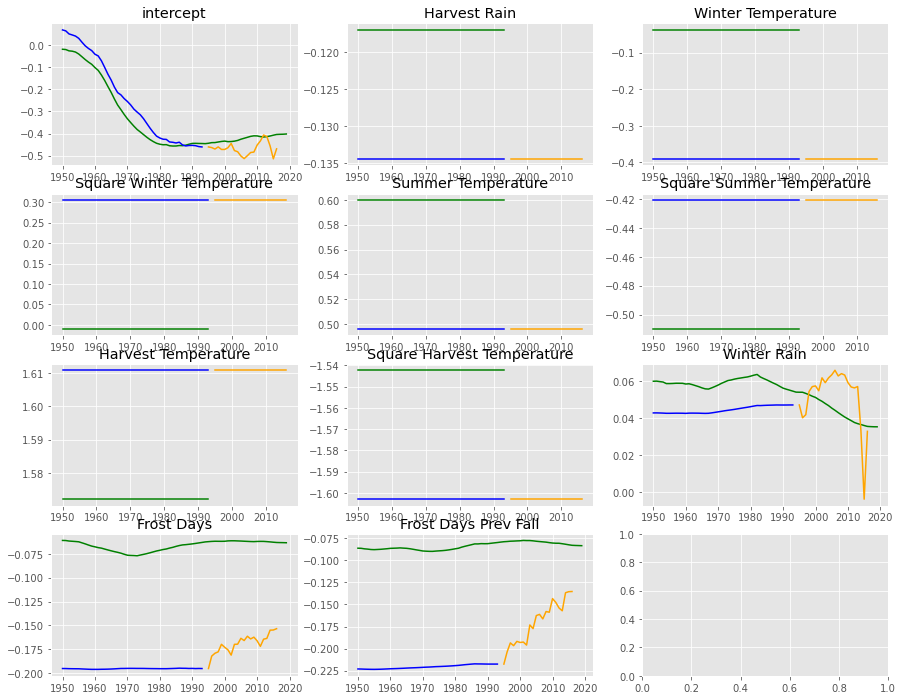

In [84]:
plt.rcParams['figure.figsize']= [15, 12]

fig, axs = plt.subplots(4,3)
print(coefficients_record.keys())
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(1950, 2020), model.weights_intercept.detach().numpy(), color='green')
subplot.plot(range(1950, 1994), vintage_model_1994.weights_intercept.detach().numpy(), color='blue')

subplot.plot(range(1995, 2017), coefficients_record[coeff], color='orange')
subplot.set_title('intercept')
    
for i in range(len(vintage_model_1994.scalar_params)):
    n = i+1
    subplot = axs[n//3, n%3]
    coeff = COLUMN_NAMES[vintage_model_1994.where_to_find_scalars[i]]
    subplot.plot(range(1950, 1994), [model.scalar_params[i]]*44, color='green')
    subplot.plot(range(1950, 1994), [vintage_model_1994.scalar_params[i]]*44, color='blue')

    subplot.plot(range(1995, 2017), coefficients_record[coeff], color='orange')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_scalars[i]])

    
for i in range(len(vintage_model_1994.walk_params)):
    n = len(vintage_model_1994.scalar_params) + i+1
    subplot = axs[n//3, n%3]
    coeff = COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]]

    subplot.plot(range(1950, 2020), model.walk_params[i].detach().numpy(), color='green')
    subplot.plot(range(1950, 1994), vintage_model_1994.walk_params[i].detach().numpy(), color='blue')

    subplot.plot(range(1995, 2017), coefficients_record[coeff], color='orange')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])

